# Data Modeling

Ultimately, using the hospitalizations identified in the `DataExploration` notebook, I fit various logistic regression models. The bottom of this notebook interprets the model's coefficients.

I selected logistic regression because it's what I would realistically choose first in a situation like this, where interpretability and prediction are both reasonably important and the number of covariates is very small. Critically, all of the covariates are naturally interpretable; age, gender, and race are comprehensible without additional transformation.

Here are some things I would have liked to do but didn't get around to doing:
 - My validation approach (20-fold cross validation) is overly simplistic; realistically there is leakage between train and test, as patient hospitalizations are not independent events. A minimally reasonable approach, and the reason the `hdf` below contains provider information, would be to create 1 test fold for each provider. Creating a single temporally-bounded test set could be reasonable as well, although it would have to be done carefully.
 - Given the small number of covariates, a highly-interpretable risk-scoring model is likely to perform reasonably well. For example, one might use [FasterRisk](https://github.com/jiachangliu/FasterRisk) to fit an integer-only risk model.
 - The hyperparameter search I implemented is very cursory. Given the small size of the dataset, doing a more detailed search is probably overkill, but I would still expect to use a more elaborate test harness in situations where prediction is important.
 - The definition of hospitalizations I used (as implemented in `covid_modeling.io.DataLoader`) is probably questionable; modeling in a situation like this (where I have no knowledge of the data-generating process) is fairly unreasonable.  If there were no mechanism to better understand the data-generating process (such as via a SME or dataset documentation), drawing conclusions from this data would be unethical (and unwarranted).  In particular, noise in the application of SNOMED CT codes is something I mention in the `DataExploration` notebook, but I ultimately decided to be out-of-scope for this particular exploration. (For example, one might try to impute missing reason-codes or correct erroneous reason codes where there is reason to suspect a COVID-19 diagnosis.)
 - "Interpretable" is always contextual. I chose logistic regression because it is a language familiar to many data scientists and subject-matter experts---potentially even more familiar than a decision tree!  However, for particular types of clinical practitioners, I would try to create a much simpler model (e.g. using only a single covariate, or the integer-only model mentioned above).

In [1]:
import pathlib
import sys
import warnings
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
import sklearn.model_selection
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm

In [2]:
# Using Jupyter magic + git to identify the data within the repository
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = pathlib.Path(git_root_dir[0])
data_dir = git_root_dir / "data"
assert data_dir.exists(), f"Expected directory '{data_dir}' to exist."
data_dir

PosixPath('/Users/levoniaz/repos/covid-data-analysis/data')

In [3]:
figures_dir = git_root_dir / "figures"
figures_dir.mkdir(exist_ok=True)

In [4]:
# isort: off
# casual Jupyter hack to make it easy to import and develop an external Python module
# this is not good practice (but it's fine during development)
sys.path.append(str(git_root_dir / "src"))
import covid_modeling.io
import covid_modeling.modeling

In [5]:
# load and process the data
# see the `DataExploration` notebook for details
data_loader = covid_modeling.io.DataLoader(data_dir)
hdf = data_loader.get_covid_hospitalizations_dataframe()
hdf.sample(n=1)

,patient,startdate,stopdate,is_covid_hospitalization,is_covid_death,leading_provider,duration,birthdate,gender,race,age
169,1768e33d-96a0-47ab-8349-ea7c82bc70a4,2020-03-10 07:13:03,2020-03-22 09:01:03,True,False,fb558fe2-f4ce-39c0-8a4a-1f5e84300113,12 days 01:48:00,1962-09-15,M,white,20996 days 07:13:03


In [6]:
# validate correct data processing
assert np.all(hdf.is_covid_hospitalization)

In [7]:
# convert age to float and scale to years
hdf["age"] = hdf.age.map(lambda td: td / timedelta(days=365))

In [8]:
# convert outcome to dummy var
hdf["covid_death"] = hdf.is_covid_death.astype(int)
hdf.covid_death.value_counts() / len(hdf)

0    0.815212
1    0.184788
Name: covid_death, dtype: float64

In [9]:
# convert gender to dummy var
hdf["is_female"] = (hdf.gender == "F").astype(int)

In [10]:
# hacky, but to make the model formulas less verbose we rename 'white' so it comes first alphabetically
# this sets 'white' as the default categorical level (i.e. the omitted column)
# this raises concerns about "white as default", but reflects the proportions
hdf["race_"] = hdf.race.map(lambda r: "_" + r if r == "white" else r)
hdf.race_.value_counts()

_white    1556
black      171
asian      134
native       6
Name: race_, dtype: int64

In [11]:
# speaking of fraught modeling decisions,
# we can also consider models where the non-white categories are combined
# to produce a dummy variable requiring only a single coefficient
hdf["is_nonwhite"] = (hdf.race != "white").astype(int)
hdf.is_nonwhite.value_counts()

0    1556
1     311
Name: is_nonwhite, dtype: int64

In [12]:
pd.crosstab(hdf.race, hdf.gender, margins=True)

gender,F,M,All
race,,,
asian,63,71,134
black,81,90,171
native,3,3,6
white,855,701,1556
All,1002,865,1867


In [13]:
# death rate by race and gender
pd.crosstab(hdf.race, hdf.gender, values=hdf.covid_death, aggfunc=lambda g: f"{g.sum() / len(g):.1%}", margins=True)

gender,F,M,All
race,,,
asian,12.7%,19.7%,16.4%
black,12.3%,24.4%,18.7%
native,33.3%,0.0%,16.7%
white,15.1%,23.0%,18.6%
All,14.8%,22.8%,18.5%


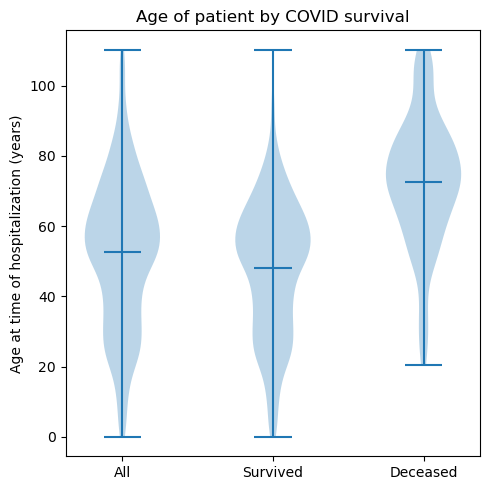

In [14]:
# patient survival by age
# looks like age correlates with survival
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.violinplot([hdf.age, hdf[~hdf.is_covid_death].age, hdf[hdf.is_covid_death].age], showmeans=True)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["All", "Survived", "Deceased"])
ax.set_ylabel("Age at time of hospitalization (years)")
ax.set_title("Age of patient by COVID survival")

fig.tight_layout()
fig.savefig(figures_dir / "survival_by_age.png", dpi=300)
plt.show()

In [15]:
# lets fit and compare different models
# note we're using R/Patsy model syntax here
model_formulas = [
    ("Gender Only", "covid_death ~ is_female"),
    ("Race Only", "covid_death ~ race_"),
    ("Age Only", "covid_death ~ age"),
    ("R+A", "covid_death ~ race_ + age"),
    ("G+A", "covid_death ~ is_female + age"),
    ("G+R", "covid_death ~ is_female + race_"),
    ("G+R+A", "covid_death ~ is_female + race_ + age"),
    ("All Interactions", "covid_death ~ is_female + race_ + age + is_female*race_*age"),
    ("Age/Gender Ints", "covid_death ~ is_female + race_ + age + is_female*age"),
    ("Age/Gender Ints No Race", "covid_death ~ is_female + race_ + age + is_female*age"),
    ("Age/Race Ints", "covid_death ~ is_female + race_ + age + race_*age"),
    ("Race/Gender Ints", "covid_death ~ is_female + race_ + age + race_*is_female"),
    ("G+A+binary Race", "covid_death ~ is_female + is_nonwhite + age"),
]
print(f"Considering {len(model_formulas)} different model configurations.")

Considering 13 different model configurations.


In [16]:
results = covid_modeling.modeling.evaluate_models(hdf, model_formulas)

100%|█████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


In [17]:
# F1 is our "gold-standard" metric here, i.e. the metric we will use for model selection
# absent any better information about our goals, this places an emphasis on predicting deaths correctly
# looks like the Age/Gender Ints model is the best; we'll choose the one without race by the principle of simplicity
pd.DataFrame(results).sort_values(by=["f1", "roc_auc"], ascending=False).head(40)

,model_name,l2,f1,roc_auc
8,G+A,False,0.463654,0.830890
16,Age/Gender Ints,False,0.459725,0.828690
18,Age/Gender Ints No Race,False,0.459725,0.828690
24,G+A+binary Race,False,0.458824,0.831185
20,Age/Race Ints,False,0.458824,0.827500
9,G+A,True,0.454728,0.650956
4,Age Only,False,0.454183,0.825325
12,G+R+A,False,0.452756,0.827991
6,R+A,False,0.451098,0.822722
25,G+A+binary Race,True,0.445783,0.647072


In [18]:
# let's interpret the best model and pull out the modeling code for a closer look
formula = "covid_death ~ is_female + age + age:is_female"
md = smf.logit(formula=formula, data=hdf)
res = md.fit(method="newton", disp=False)
params = res.params
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            covid_death   No. Observations:                 1867
Model:                          Logit   Df Residuals:                     1863
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Mar 2023   Pseudo R-squ.:                  0.2547
Time:                        18:51:25   Log-Likelihood:                -665.97
converged:                       True   LL-Null:                       -893.50
Covariance Type:            nonrobust   LLR p-value:                 2.601e-98
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.5402      0.414    -13.374      0.000      -6.352      -4.728
is_female        -1.2376      0.635     -1.950      0.051      -2.481       0.006
age               0.0721      0.006     11.502      0.000       0.060       0.084
age:is_female     0.0086      0.009      0.919      0.358      -0.010       0.027
=================================================================================
"""

In [19]:
kfold = sklearn.model_selection.KFold(n_splits=20, shuffle=False)
y_score = np.zeros(len(hdf))
for train_index, test_index in kfold.split(hdf):
    train_df = hdf.iloc[train_index]
    test_df = hdf.iloc[test_index]
    try:
        formula = "covid_death ~ is_female + age + is_female:age"
        md = smf.logit(formula=formula, data=train_df)
        res = md.fit(method="newton", disp=False)
        preds = res.predict(test_df)
        y_score[test_index] = preds
    except:
        y_score[test_index] = 0  # majority-class prediction
y_true = hdf.covid_death
y_pred = (y_score >= 0.5).astype(int)

In [20]:
print(sklearn.metrics.classification_report(y_true, y_pred, target_names=["survived", "deceased"]))
print()
print(f"Accuracy: {(y_true == y_pred).sum() / len(y_true):.1%}")
print(f"ROC AUC: {sklearn.metrics.roc_auc_score(y_true, y_score):.3f}")

              precision    recall  f1-score   support

    survived       0.87      0.97      0.92      1522
    deceased       0.72      0.34      0.46       345

    accuracy                           0.85      1867
   macro avg       0.80      0.66      0.69      1867
weighted avg       0.84      0.85      0.83      1867


Accuracy: 85.4%
ROC AUC: 0.832


In [21]:
np.exp(params)

Intercept        0.003926
is_female        0.290087
age              1.074788
age:is_female    1.008605
dtype: float64

In [22]:
print(
    f"A 1-year increase in patient age is associated with a {np.exp(params.age) - 1:.2%} increase in the odds of patient death."
)
for age in [50, 60, 70, 80]:
    print(
        f"For the average {age}-year-old, being female rather than male is associated with a {1 - np.exp(params.is_female + params['age:is_female']*age):.2%} decrease in the odds of patient death."
    )
print("By the assumptions of the reported model, race has zero impact on the odds of patient death.")

A 1-year increase in patient age is associated with a 7.48% increase in the odds of patient death.
For the average 50-year-old, being female rather than male is associated with a 55.48% decrease in the odds of patient death.
For the average 60-year-old, being female rather than male is associated with a 51.49% decrease in the odds of patient death.
For the average 70-year-old, being female rather than male is associated with a 47.15% decrease in the odds of patient death.
For the average 80-year-old, being female rather than male is associated with a 42.43% decrease in the odds of patient death.
By the assumptions of the reported model, race has zero impact on the odds of patient death.


In [23]:
# to validate our result about the non-importance of race, we can fit a model including race
# note the wide confidence intervals for the is_nonwhite variable
formula = "covid_death ~ is_female + age + is_nonwhite"
md = smf.logit(formula=formula, data=hdf)
res = md.fit(method="newton", disp=False)
params = res.params
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            covid_death   No. Observations:                 1867
Model:                          Logit   Df Residuals:                     1863
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Mar 2023   Pseudo R-squ.:                  0.2549
Time:                        18:51:25   Log-Likelihood:                -665.77
converged:                       True   LL-Null:                       -893.50
Covariance Type:            nonrobust   LLR p-value:                 2.121e-98
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.7794      0.316    -18.305      0.000      -6.398      -5.161
is_female      -0.6816      0.140     -4.862      0.000      -0.956      -0.407
age             0.0765      0.005     16.376      0.000       0.067       0.086
is_nonwhite    -0.2103      0.189     -1.110      0.267      -0.582       0.161
===============================================================================
"""